# **손글씨 숫자 분류**
손글씨 데이터 집합에서 손으로 쓴 숫자 분류를 CNN을 통해 구축 및 Training. 60,000의 training datas와 10,000의 test images로 구성. 숫자는 0~9까지.

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

     |████████████████████████████████| 2.1MB 7.0MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114586 sha256=8ad9369b66c9574a6d7abd73f2aaa6f6c56a30bca4831b75897f1a82acb21641
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


좌측 상단의 런타임 -> 런타임 유형 변경 -> 하드웨어 가속기를 GPU로 설정

In [ ]:
from tensorflow.python.client import device_lib
    
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7914726528267784603, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8542308057999937228
 physical_device_desc: "device: XLA_CPU device"]

# 1. 데이터 다운로드 및 샘플 데이터 표시

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

11493376/11490434 [==============================] - 0s 0us/step


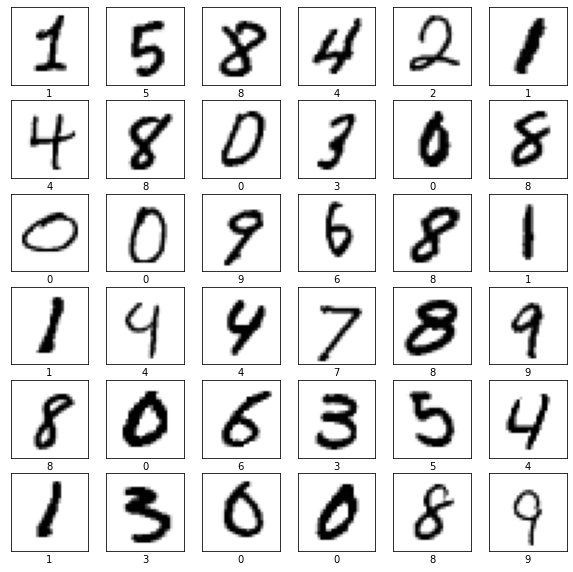

In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

# 2. Neural Network for Handwritten Digit Classification

연결된 두개의 층으로 구성된 simple neural network를 구축한 후 숫자분류에 적용.
10자리 class(0~9)의 확률분포를 산출

![대체 텍스트](https://camo.githubusercontent.com/7f13ef1c97aec9645328dd737529088ebf7b9f77/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f61616d696e692f696e74726f746f646565706c6561726e696e672f6d61737465722f6c6162322f696d672f6d6e6973745f326c61796572735f617263682e706e67)

Fully connected layers의 정의를 위해 Keras API를 정의, Sequential class를 사용해 모델 정의.
Input값을 model에 사용할 수 있게 Flatten


이미지 형식을 2d array(28x28 픽셀)에서 28*28=784 픽셀의 1d array로 flatten. 이 layer에서는 학습된 parameter가 없고 데이터만 재구성 됨.

픽셀을 flatten시킨 후 두개의 dence layers로 구성. 첫번째 dence layer는 128개의 노드를 가지고 있고 두번째 dence layer는 합이 1인 probability scores를 return 해야 함. 각 노드에는 현재 이미지가 손글씨 숫자 class중 하나에 속할 가능성을 나타내는 score가 들어 있음.

model을 update하려면 아래 셀을 다시 실행해 초기화.

In [ ]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # Flatten layers 정의
      tf.keras.layers.Flatten(),

      # 양의 값만 산출해야 식별하기 용이하기 때문에 activation = relu
      tf.keras.layers.Dense(128, activation=tf.nn.relu),

      # softmax함수는 입력받은 값을 0에서 1사이의 값으로 모두 정규화하며, 출력 값이 여러개
      # 출력 값의 총합은 항상 1이 되는 특징을 가집니다. 다중 클래스 문제에 적용 가능, 정규화 기능
      tf.keras.layers.Dense(10, activation=tf.nn.softmax) 
      
  ])
  return fc_model

model = build_fc_model()

**Compile the model**

Loss function : training model이 얼마나 정확한지 측정하는 방법. loss function을 최소화하고 올바른 방향으로 "steer"

optimizer : data와 loss function을 기반으로 모델이 업데이트되는 방법

metrics : training과 test 단계를 모니터링하는데 사용되는 metrics를 정의. 이 예시에서는 이미지가 정확히 분류되었는지의 정확성을 확인.

learning rate 0.1로 초기화된 SGD optimizer를 사용. 범주형 분류 작업을 하기 때문에 cross entropy loss를 사용.

cross entropy loss 설명 : https://3months.tistory.com/436

![대체 텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FNq9TL%2FbtqxdqsIG99%2Fc9IiTiHBDp4cgCUtYXPSzk%2Fimg.png)

choice of optimizer, learning rate를 사용해 실험하고 training model의 정확도에 어떤 영향을 미치는지 평가.

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [ ]:
'''다양한 optimizer, learning rate로 실험, 정확성에 어떠한 영향을 끼치고 어떤 optimizer, learning rate가 가장 우수한가?'''
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**

train images와 train labels를 model에 feeding, images와 labels의 연관성을 learning하도록 하는 model을 training할 준비가 됨. training 중 사용할 손글씨 데이터 집합에 대한 batch size와 number of epochs, 반복횟수를 정의 해야 함.

In [ ]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3746 - accuracy: 0.8962
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1999 - accuracy: 0.9429
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1484 - accuracy: 0.9578
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1191 - accuracy: 0.9662
Epoch 5/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0997 - accuracy: 0.9717


epochs=5, learning rate=0.01인 이 model은 traing data에서 약 97%의 정확도를 achieve

**Evaluate accuracy on the test dataset**



정확도를 평가하기 위해 모델의 예측이 test_labels array와 label이 일치하는지 확인

In [ ]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(test_images, test_labels) # TODO
# test_loss, test_acc = # TODO

print('Test accuracy:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.1101 - accuracy: 0.9669
Test accuracy: 0.9668999910354614


test dataset의 정확도가 training dataset의 정확도 보다 조금 낮은 것을 확인할 수 있는데 이 차이는 overfitting의 예시.

# 3 Convolutional Neural Network (CNN) for handwritten digit classification

CNN은 Computer Vision의 다양한 작업에 적합. 두 개의 convolution layers, pooling layers로 구성된 CNN을 구축해 Fully connected layers 2개를 이어받아 최종적으로 10 digit calsses에 걸쳐서 확률분포를 산출

![대체 텍스트](https://camo.githubusercontent.com/c30cdefcee25966f59bcb3ea38632ebea83ce45f/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f61616d696e692f696e74726f746f646565706c6561726e696e672f6d61737465722f6c6162322f696d672f636f6e766e65745f6669672e706e67)

**Define the CNN model**

Fully connected network와 비슷하게 진행해 새로운 CNN model training and define

keras.layers.Conv2D : convolution layers를 define (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

keras.layers.MaxPool2D : pooling layers를 define (https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)


In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),

        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),


        tf.keras.layers.MaxPool2D(pool_size=(2,2)),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        # [TODO Dense layer to output classification probabilities]
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  115328    
_________________________________________________________________
dense_3 (Dense)              multiple                 

**Train and test the CNN model**

loss function, optimizer, metrics를 define, optimizer와 learning rate choice로 CNN model compile

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# cnn_model.compile(optimizer='''TODO''', loss='''TODO''', metrics=['accuracy']) # TODO

Fully connected model과 마찬가지로 keras API를 통한 적합으로 CNN training, model 평가

In [ ]:
'''TODO: Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)
# cnn_model.fit('''TODO''')

Epoch 1/5
938/938 [==============================] - 35s 37ms/step - loss: 0.1739 - accuracy: 0.9496
Epoch 2/5
938/938 [==============================] - 35s 38ms/step - loss: 0.0532 - accuracy: 0.9838
Epoch 3/5
938/938 [==============================] - 35s 38ms/step - loss: 0.0361 - accuracy: 0.9885
Epoch 4/5
938/938 [==============================] - 36s 38ms/step - loss: 0.0271 - accuracy: 0.9917
Epoch 5/5
938/938 [==============================] - 36s 39ms/step - loss: 0.0201 - accuracy: 0.9936


In [ ]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
# test_loss, test_acc = # TODO

print('Test accuracy:', test_acc)

313/313 [==============================] - 3s 10ms/step - loss: 0.0407 - accuracy: 0.9853
Test accuracy: 0.9853000044822693


**Make predictions with the CNN model**

predict function을 사용해 주어진 input samples로 output predictions를 생성.

In [ ]:
predictions = cnn_model.predict(test_images)

각 images의 labels을 예측.

In [ ]:
predictions[0]

array([1.02577594e-07, 9.09730069e-09, 4.77472531e-06, 8.80927473e-06,
       2.84931234e-09, 1.56238456e-09, 2.26280127e-12, 9.99984026e-01,
       1.45673675e-06, 8.13080419e-07], dtype=float32)

10개의 숫자배열. 10자리 class에 대한 확률분포(신뢰도).

In [ ]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions[0]) 

print(prediction)

7


Label of this digit is: 7


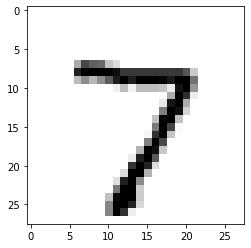

In [ ]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

MNIST data set 분류 결과(images, labels)를 시각화.

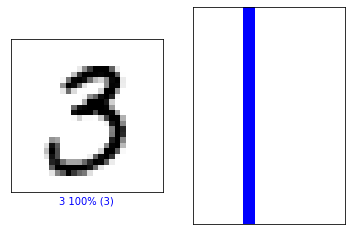

In [ ]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 90 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions,  test_labels)

prediction labels가 정확하면 파란색, 부정확하면 빨간색.

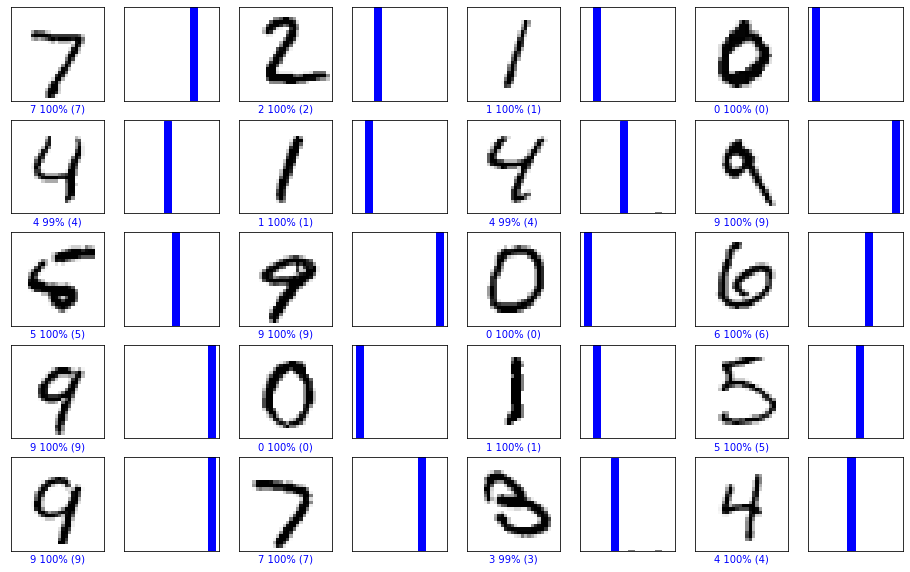

In [ ]:

# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)

# **4. Training the model 2.0**

GradientTape class는 training 중 차별화 작업을 기록한 다음 tf를 call. GradientTape.gradient 함수를 사용하여 그라데이션 값을 실제로 계산

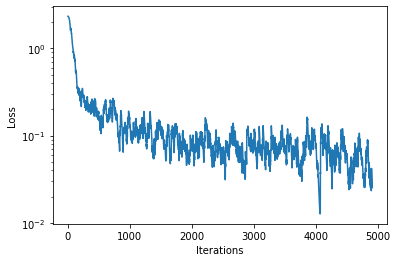

100%|██████████| 5000/5000 [02:01<00:00, 41.27it/s]


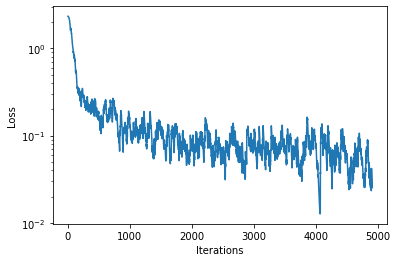

In [ ]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    logits = cnn_model(images)
    # logits = # TODO

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits)
    # loss_value = tf.keras.backend.sparse_categorical_crossentropy() # TODO

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.''' 
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  # grads = # TODO
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))